# Tail Estimators
Unobserved loss experience beyond the edge of a Triangle can be substantial and is a necessary part of an actuary's analysis. This is particularly so for long tailed lines more common in commercial insurance or excess layers of loss.

With all tail estimation, we are *extrapolating* beyond the known data which comes with its own challenges. It tends to be more difficult to validate assumptions when performing tail estimation.  Additionally, many of the techniques carry a high degree of sensitivity to the assumptions you will choose when conducting analysis. 

Nevertheless, it is a necessary part of the actuary's toolkit in estimating reserve liabilities.

In [1]:
import chainladder as cl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

## Basics and Commonalities
As with the `Development` family of estimators, the `Tail` module provides a variety of tail **transformers** that allow for the extrapolation of development patterns beyond the end of the triangle. Being transformers, we can expect that each estimator has a `fit` and a `transform` method.  It is also expected that the `transform` method will give us back our Triangle with additional estimated parameters for incorporating our tail review in our IBNR estimates. 

### Tail
Every tail estimator produced a `tail_` attribute which represents the point estimate of the tail of the Triangle.
```{tip}
Recall that the trailing `underscore_` implies that these parameters are only available once we've `fit` our estimator.
```

We will demonstrate this property using the [TailConstant](tails:tailconstant) estimator which we explore further below.

In [82]:
triangle = cl.load_sample('genins')
tail = cl.TailConstant(1.10).fit_transform(triangle)
tail.tail_

,120-Ult
(All),1.1


### Run Off

In addition to point estimates, tail estimators support run-off analysis.  The
`ldf_` and `cdf_` attribute splits the tail point estimate into enough
development patterns to allow for tail run-off to be examined for at least another
valuation year by default. For an annual `development_grain` grain, the development pattterns
include two additional patterns.

In [83]:
tail.cdf_

,12-Ult,24-Ult,36-Ult,48-Ult,60-Ult,72-Ult,84-Ult,96-Ult,108-Ult,120-Ult,132-Ult
(All),15.8912,4.5526,2.6054,1.7877,1.5229,1.3797,1.2701,1.2052,1.1195,1.1000,1.0514


```{note}
When fitting a tail estimator without first specifying a `Development` estimator first, `chainladder` assumes a volume-weighted `Development`.   To override this, you should declare transform your triangle with a development transformer first.
```

For quarterly grain, there are five additional development patterns and for monthly
there are thirteen.



In [84]:
triangle = cl.load_sample('quarterly')['paid']
tail = cl.TailCurve().fit(triangle)
# Slice just the tail entries
tail.cdf_[~tail.ldf_.development.isin(triangle.link_ratio.development)]

,135-Ult,138-Ult,141-Ult,144-Ult,147-Ult
(All),1.0006,1.0005,1.0004,1.0004,1.0003


```{note}
The point estimate `tail_` of the tail is the CDF for 135-Ult. The remaining CDFs simply represent the run-off of this tail as specified by the Tail estimator in use.
```

### Attachment Age

By default, tail estimators attach to the oldest `development` age of the `Triangle`.
In practice, the last several known development factors of a `Triangle` can be
unreliable and attaching the tail earlier and using it as a smoothing mechanism
is preferred.  All tail estimators have an `attachment_age` parameter that
allows you to select the development age to which the tail will attach.

In [85]:
triangle = cl.load_sample('genins')
unsmoothed = cl.TailCurve().fit(triangle).ldf_
smoothed = cl.TailCurve(attachment_age=24).fit(triangle).ldf_

In this way, we can smooth over any volatile development patterns.

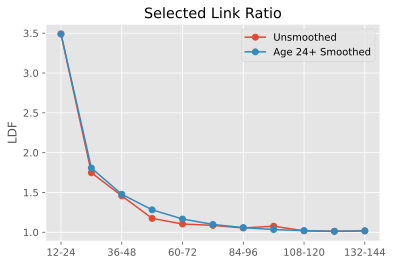

In [86]:
pd.concat((
    unsmoothed.T.iloc[:, 0].rename('Unsmoothed'),
    smoothed.T.iloc[:, 0].rename('Age 24+ Smoothed')),
    axis=1).plot(marker='o', title='Selected Link Ratio', ylabel='LDF');

### Projection period

Regardless of where you attach a tail, there will be incremental patterns to at
least one year past the end of the `Triangle` to support run-off analysis.

This accommodates views of run-off for the oldest origin periods in your triangle for at least another year.  As actuarial reviews typically occur no less than annually, this should be sufficient for examining run-off performance between actuarial valuations.

Cases arise where modeling run-off on a longer time horizon is desired.  For these cases, it is possible to modify the `projection_period` (in months) of all Tail Esimtators by specifying the number of months you wish to extend your patterns.

In [89]:
# Extend tail run-off 4 years past end of Triangle.
tail = cl.TailCurve(projection_period=12*4).fit(triangle)
tail.ldf_[~tail.ldf_.development.isin(triangle.link_ratio.development)]

,120-132,132-144,144-156,156-168,168-180
(All),1.0119,1.0071,1.0042,1.0025,1.0036


In this example, we see a higher development pattern for the last period than the ones prior.  This is because the true tail run-off exceeds four years.  To be clear, the `projection_period` has no effect on the actual estimated tail, it simply provides a longer time horizon for measuring run-off.

(tails:tailconstant)=
## TailConstant

`TailConstant` allows you to input a tail factor as a constant.  This is
useful when relying on tail selections from an external source like industry data.

The tail factor supplied applies to all individual triangles contained within
the Triangle object.  If this is not the desired outcome, slicing individual
triangles and applying `TailConstant` separately to each can be done.

### Decay

For run-off analysis, you can control the decay of your tail.  An exponential
`decay` parameter is also available to facilitate the run off analysis described
above.

In [80]:
tail = cl.TailConstant(tail=1.05, decay=0.95).fit_transform(triangle)
tail.ldf_

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120,120-132,132-144
(All),3.4906,1.7473,1.4574,1.1739,1.1038,1.0863,1.0539,1.0766,1.0177,1.0024,1.0474


As we can see in the example, the 5% tail in the example is split between the
amount to run-off over the subsequent calendar period **132-144**, and the
remainder, **144-Ult**.  The split is controlled by the `decay` parameter. We
can always reference our `tail_` point estimate.

In [81]:
tail.tail_

,120-Ult
(All),1.05


### Examples

:::{panels}
:column: col-lg-4 px-2 py-2

---
**[DevelopmentConstant Callable](plot_callable_dev_constant)**
```{glue:} plot_callable_dev_constant
```
+++
{bdg-danger}`hard`
:::

(tails:tailcurve)=
## TailCurve

`TailCurve` allows for extrapolating a tail factor using curve fitting.
Currently, exponential decay of LDFs and inverse power curve are supported.

In [11]:
clrd = cl.load_sample('clrd').groupby('LOB').sum()['CumPaidLoss']
cdf_ip = cl.TailCurve(curve='inverse_power').fit(clrd).tail_
cdf_xp = cl.TailCurve(curve='exponential').fit(clrd).tail_

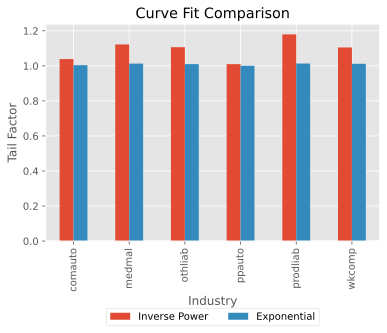

In [12]:
ax = pd.concat((cdf_ip.rename("Inverse Power"),
           cdf_xp.rename("Exponential")), axis=1).plot(
        kind='bar', title='Curve Fit Comparison',
        xlabel='Industry', ylabel='Tail Factor')

ax.legend(loc='center', bbox_to_anchor=(.5, -.35), facecolor='white', ncol=2);

### Regression parameters

Underlying the curve fit is an OLS regression which generates both a `slope_`
and `intercept_` term.

For the `exponential` curve fit with slope, $\beta$ and intercept $\alpha$, the tail factor
is:


$$
\prod_{i}^{N}1+exp(\beta X+\alpha )
$$ (tail_exponential_eq)

For the `inverse_power` curve, the tail factor is:

$$
\prod_{i}^{N}1+exp(\alpha) X^{\beta}
$$ (tail_inverse_power_eq)

Where $X$ is your selected link ratios and $N$ is the number of years you wish to extrapolate the `tail_`

Deriving the `tail_` factor manually:

In [13]:
triangle = cl.load_sample('genins')
tail = cl.TailCurve('exponential').fit(triangle)
tail.tail_

,120-Ult
(All),1.029499


A manual calculation using {eq}`tail_exponential_eq` above:

In [14]:
np.prod(
    (1+np.exp(
        np.arange(triangle.shape[-1],
                  triangle.shape[-1] + tail.extrap_periods) * 
        tail.slope_.values + tail.intercept_.values)
    )
)

1.0294991710529175

For completeness, let's also confirm {eq}`tail_inverse_power_eq`:

In [15]:
tail = cl.TailCurve('inverse_power').fit(triangle)
tail.tail_

,120-Ult
(All),1.29243


In [16]:
np.prod(
    1 + np.exp(tail.intercept_.values) * 
    (
        np.arange(
            triangle.shape[-1], 
            triangle.shape[-1] + tail.extrap_periods
        ) ** tail.slope_.values)
)

1.292430311543694

### Extrapolation Period

From these formulas, the actuary has control over the parameter, $N$ which 
represents how far out how far beyond the edge of Results for the `inverse_power`
curve are sensitive to this parameter as it tends to converge slowly to its
asymptotic value. This parameter can be controlled using the `extrap_periods`
hyperparamter.

```{tip}
Exponential decay is generally rapid and is less sensitive to the `extrap_period` 
argument than the inverse power fit.
```

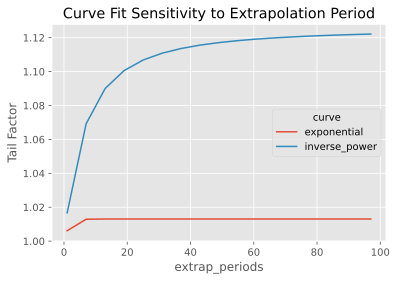

In [17]:
tri = cl.load_sample('clrd').groupby('LOB').sum().loc['medmal', 'CumPaidLoss']

# Create a fuction to grab the scalar tail value.
def scoring(model):
    """ Scoring functions must return a scalar """
    return model.tail_.iloc[0, 0]

# Create a grid of scenarios
param_grid = dict(
    extrap_periods=list(range(1, 100, 6)),
    curve=['inverse_power', 'exponential'])

# Fit Grid
model = cl.GridSearch(cl.TailCurve(), param_grid=param_grid, scoring=scoring).fit(tri)

# Plot results
model.results_.pivot(columns='curve', index='extrap_periods', values='score').plot(
    grid=True, ylim=(1,None), title='Curve Fit Sensitivity to Extrapolation Period').set(
    ylabel='Tail Factor');

This example demonstrates the `extrap_periods` functionality of the TailCurve estimator. The estimator defaults to extrapolating out 100 periods. However, we can see that the "Inverse Power" curve fit doesn't converge to its asymptotic value even with 100 periods whereas the "exponential" converges within 10 periods.

### Fit period
The default behavior of `TailCurve` is to include all `cdf_` patterns from the Triangle in extrapolating the tail.  Often, the data assumptions of linearity will be violated when using all 
selected patterns. In those cases, you can use `fit_period=(start_age, end_age)` for fitting to a contiguous set of patterns.

In [18]:
dev = cl.Development().fit_transform(cl.load_sample('quarterly')['paid'])
fit_all = cl.TailCurve().fit(dev)
exclude = cl.TailCurve(fit_period=(36, None)).fit(dev)

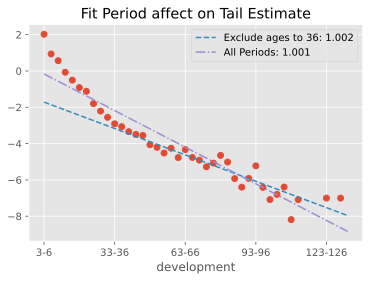

In [26]:
obs = (dev.ldf_ - 1).T.iloc[:, 0]
obs[obs < 0] = np.nan

ax = np.log(obs).rename('Selected LDF').plot(
    style=' ', marker='o', title=f'Fit Period affect on Tail Estimate');
pd.Series(
    np.arange(1, dev.ldf_.shape[-1] + 1) * exclude.slope_.sum().values + exclude.intercept_.sum().values, 
    index=dev.ldf_.development, 
    name=f'Ages after 36: {round(exclude.tail_.values[0,0], 3)}').plot(
    ax=ax, style = '--', legend=True);
pd.Series(
    np.arange(1, dev.ldf_.shape[-1] + 1) * fit_all.slope_.sum().values + fit_all.intercept_.sum().values, 
    index=dev.ldf_.development, 
    name=f'All Periods: {round(fit_all.tail_.values[0,0], 3)}').plot(
    ax=ax, style = '-.', legend=True);

```{warning}
The nature of curve fitting with `log` and `exp` transforms is inappropriate for development factors less
than 1.0.  The default behavior of `TailCurve` is to ignore these observations when determining
the OLS regression parameters. You can force errors by setting the `errors` argument to "raise".
```
```python
dev = cl.TailCurve(errors='raise')
# This will fail because of LDFs < 1 and our choice to 'raise' errors
dev.fit(cl.load_sample('quarterly')['paid'])
```

You can also use a list to of booleans to specify which values you want to include. This allows for finer grain control over excluding outliers from your analysis.  The following two estimators are
equivalent.

In [42]:
(cl.TailCurve(fit_period=[False] * 11 + [True] * 33).fit(dev).cdf_ ==
 cl.TailCurve(fit_period=(36, None)).fit(dev).cdf_)

True

### Examples

:::{panels}
:column: col-lg-4 px-2 py-2

---
**[Attachment Age Smoothing](plot_exponential_smoothing)**
```{glue:} plot_exponential_smoothing
```
+++
{bdg-success}`easy`

---
**[TailCurve Extrapolation](plot_extrap_period)**
```{glue:} plot_extrap_period
```
+++
{bdg-warning}`medium`

---
**[TailCurve Basics](plot_tailcurve_compare)**
```{glue:} plot_tailcurve_compare
```
+++
{bdg-success}`easy`
:::
{cite}`CAS_TFWP2013`

(tails:tailbondy)=
## TailBondy
Most people are familiar with the Bondy tail know it as a basic method that assumes the 
`tail_` is just a repeat of the last available `ldf_`.

Indeed, without any hyperparameter selection, this is how `TailBondy` works.


In [55]:
triangle = cl.load_sample('genins')
dev = cl.Development().fit_transform(triangle)
dev.ldf_.iloc[..., -1]

,108-120
(All),1.0177


In [10]:
tail = cl.TailBondy().fit(triangle)
tail.tail_

,120-Ult
(All),1.017725


This simple relationship has a more generalized form.  If we define the `ldf_` at time $n$ as $f(n-1)$
and assume that $f(n) = f(n-1)^{B}$, it follows that the tail $F(n)$ can be defined as:

$$
F(n)=f(n-1)^{B}f(n-1)^{B^{2}}...=f(n-1)^{\frac{B}{1-B}}
$$ (tail_bondy_eq)

where $B$ is some constant, and if $B$ is $\frac{1}{2}$, then we obtain Bondy's original tail formulation.

Rather than using the only the last known development factor or setting $B=\frac{1}{2}$, we
can stablize things using more `ldf_` using the `earliest_age` parameter. We can then minimize
the difference in the the assumed relationship $f(n) = f(n-1)^{B}$ and our data to estimate $B$.

This is often refered to as the *Generalized Bondy* method.

In [45]:
triangle = cl.load_sample('tail_sample')['paid']
dev = cl.Development(average='simple').fit_transform(triangle)

# Estimate the Bondy Tail
tail = cl.TailBondy(earliest_age=12).fit(dev)
tail.tail_

,120-Ult
(All),1.027763


Using our formulation {eq}`tail_bondy_eq` above, we can manually estimate our tail using our earliest `ldf_` 
and our Bondy constant `b_`.

In [46]:
# Get last fitted LDF of the model
last_fitted_ldf = (tail.earliest_ldf_ ** (tail.b_ ** 8))

# Calculate the tail using the Bondy formula above
last_fitted_ldf ** (tail.b_ / (1-tail.b_))

,paid
Total,
Total,1.027756


{cite}`CAS_TFWP2013`

(tails:tailclark)=
## TailClark

`TailClark` is a continuation of the `ClarkLDF` model.  Familiarity
with [ClarkLDF](development:clarkldf) will aid in understanding this Estimator.
The growth curve approach used by Clark produces development patterns for any
age including ages beyond the edge of the Triangle.

An example completing Clark's model:


In [5]:
genins = cl.load_sample('genins')
dev = cl.ClarkLDF()
tail = cl.TailClark()
tail.fit(dev.fit_transform(genins)).ldf_

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120,120-132,132-144
(All),4.0949,1.7205,1.3425,1.2005,1.1306,1.0910,1.0665,1.0504,1.0393,1.0313,1.2540


Coupled with `attachment_age` one could use any Development estimator and replicate the `ClarkLDF` estimator.

In [6]:
genins = cl.load_sample('genins')
tail = cl.TailClark(attachment_age=12)
tail.fit(cl.Development().fit_transform(genins)).ldf_

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120,120-132,132-144
(All),4.0949,1.7205,1.3425,1.2005,1.1306,1.0910,1.0665,1.0504,1.0393,1.0313,1.2540


### Truncated patterns

Clark warns of the dangers of extrapolating too far beyond the edge of a Triangle,
particularly with a heavy tailed distribution.  In these cases, it is suggested that
a suitable cut-off age or ``truncation_age`` be established where losses are considered
fully developed. This is very similar to the `extrap_periods` parameter of `TailCurve`,
however, it is expressed as an age (in months) as opposed to a period length.

In [20]:
tail = cl.TailClark(truncation_age=245)
tail.fit(dev.fit_transform(genins)).cdf_

,12-Ult,24-Ult,36-Ult,48-Ult,60-Ult,72-Ult,84-Ult,96-Ult,108-Ult,120-Ult,132-Ult
(All),19.2093,4.6910,2.7266,2.0310,1.6918,1.4964,1.3715,1.2860,1.2243,1.1781,1.1423


{cite}`clark2003`